# Application Integration

Credits: **Educative.io**

Amazon Simple Notification Service (SNS) helps us send notifications to several types of endpoints/destinations, such as email addresses, text messages, and so on. SNS topic is the channel from where the communication occurs. SNS subscriptions are the endpoint for a published message on an SNS topic; subscribers can be other services of AWS, email addresses, mobile phone numbers, and so on. SNS filters enable topics to publish messages to subscribers based on certain predefined criteria. 


Amazon Simple Queue Service (SQS) is a message queuing service that can store messages for a period of time—up to 14 days, during which a consumer can try to receive the message from the queue. In case of any failure on the consumer’s side, the message won’t be lost and the consumer can retrieve the message later on. Furthermore, SQS supports dead-letter queues; if the consumer fails to receive a message a specified number of times, the message is transferred to a dead-letter queue for debugging purposes.

One of the major differences it has with an SNS topic is that the consumer is required to receive (pull) messages from an SQS queue, while an SNS topic publishes (pushes) messages to all its subscribers.

We create standard SNS topic:
arn:aws:sns:us-east-1:437550197980:TopicForQueues

and we subscribe (no encryption) 3 queues to the topic:
https://sqs.us-east-1.amazonaws.com/437550197980/JohnQueue

we then add "Subscription filter policy" (so we can provide message with some attributes (in this case that attribute is "Option")):
```json
{
  "Option": [
    "<Name>"
  ]
}
```


Let's create a new topic TopicForEmail:
arn:aws:sns:us-east-1:437550197980:TopicForEmail
this time we create subscription with email protocol and provide email address.

We now set up CloudWatch alarms for all 3 queues, so that if there are more then 5 messages in each of the queues, we send an email with message,"Queue X has reached enough messages", and we send this alarm to queue TopicForEmail we created in the previous step.
An alarm metric we'll use is: SQS > Queue Metrics > ApproximateNumberOfMessagesVisible.



## Set API


Lets create a regional REST API called `clab-API`.

#### POST API

We'll need a LabRole: `arn:aws:iam::546114071089:role/LabRole`

We first define POST method `Publish` that will publish some message to SNS topic TopicForQueues. We will use AWS API Gateway service, using AWS SNS service and IAM Role "LabRole" (ARN: arn:aws:iam::437550197980:role/LabRole).
To configure the API so "method request" needs to "validate query string and headers" and that URL query string parameter "message" is required. 
"Integration request" needs 5 URL query string parameters:
- "Message": 'Option Chosen'
- "MessageAttributes.entry.1.Name": 'Option'
- "MessageAttributes.entry.1.Value.DataType": 'String'
- "MessageAttributes.entry.1.Value.StringValue": method.request.querystring.message
- "TopicArn": 'arn:aws:sns:us-east-1:437550197980:TopicForQueues'

When we send a "message=Alexa", we in fact create this endpoint:
```
Endpoint request URI: https://sns.us-east-1.amazonaws.com/?Action=Publish&Message=Option+Chosen&TopicArn=arn:aws:sns:us-east-1:437550197980:TopicForQueues&MessageAttributes.entry.1.Name=Option&MessageAttributes.entry.1.Value.DataType=String&MessageAttributes.entry.1.Value.StringValue=Alexa
```
We finally deploy API (id: l27ksqvoud)

#### GET API

We now create a GET method for the same REST API, named "GetQueueAttributes". We'll set up 3 stages, one for each queue, and use Integration request set up as:
- "QueueUrl": 'https://sqs.us-east-1.amazonaws.com/437550197980/AlexaQueue'  (this will change for each stage)
- "AttributeNames": 'ApproximateNumberOfMessages'

and we modify integration response as:
```
#set($inputRoot = $input.path('$'))
$inputRoot.GetQueueAttributesResponse.GetQueueAttributesResult.Attributes[0].Value
```
so we get only a simple value.

# Summary 

We developed a voting application where participants can be selected as options. First, we created an SNS topic to which multiple SQS queues—each named after a participant—are subscribed. Additionally, CloudWatch alarms were configured to monitor the message count received by each queue. Moreover, we configured a REST API using API Gateway to handle requests from an application launched on an EC2 instance, where the votes can submitted. For each vote, the REST API publishes messages on an SNS topic, which sends messages to SQS queues based on certain filters. When a sufficient number of votes are accumulated for each participant, CloudWatch works with the SNS topic to send us an email notification.

# Create clients 

We now create a mock clients, that will be calling the APIs, mimicking voting for 3 candidates: John, Alexa, and Ali.

For that purpose we set up EC2 instance with some simple UI that runs election:

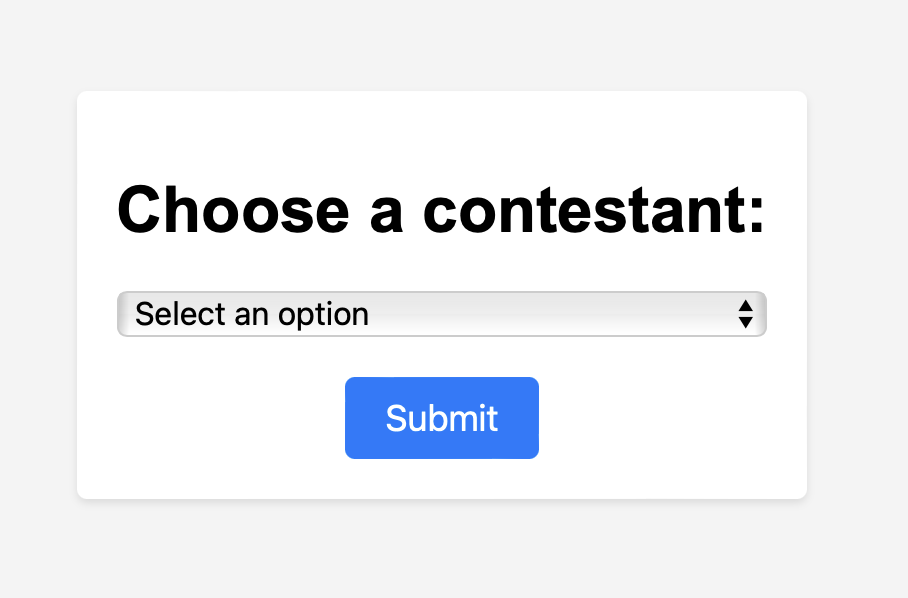

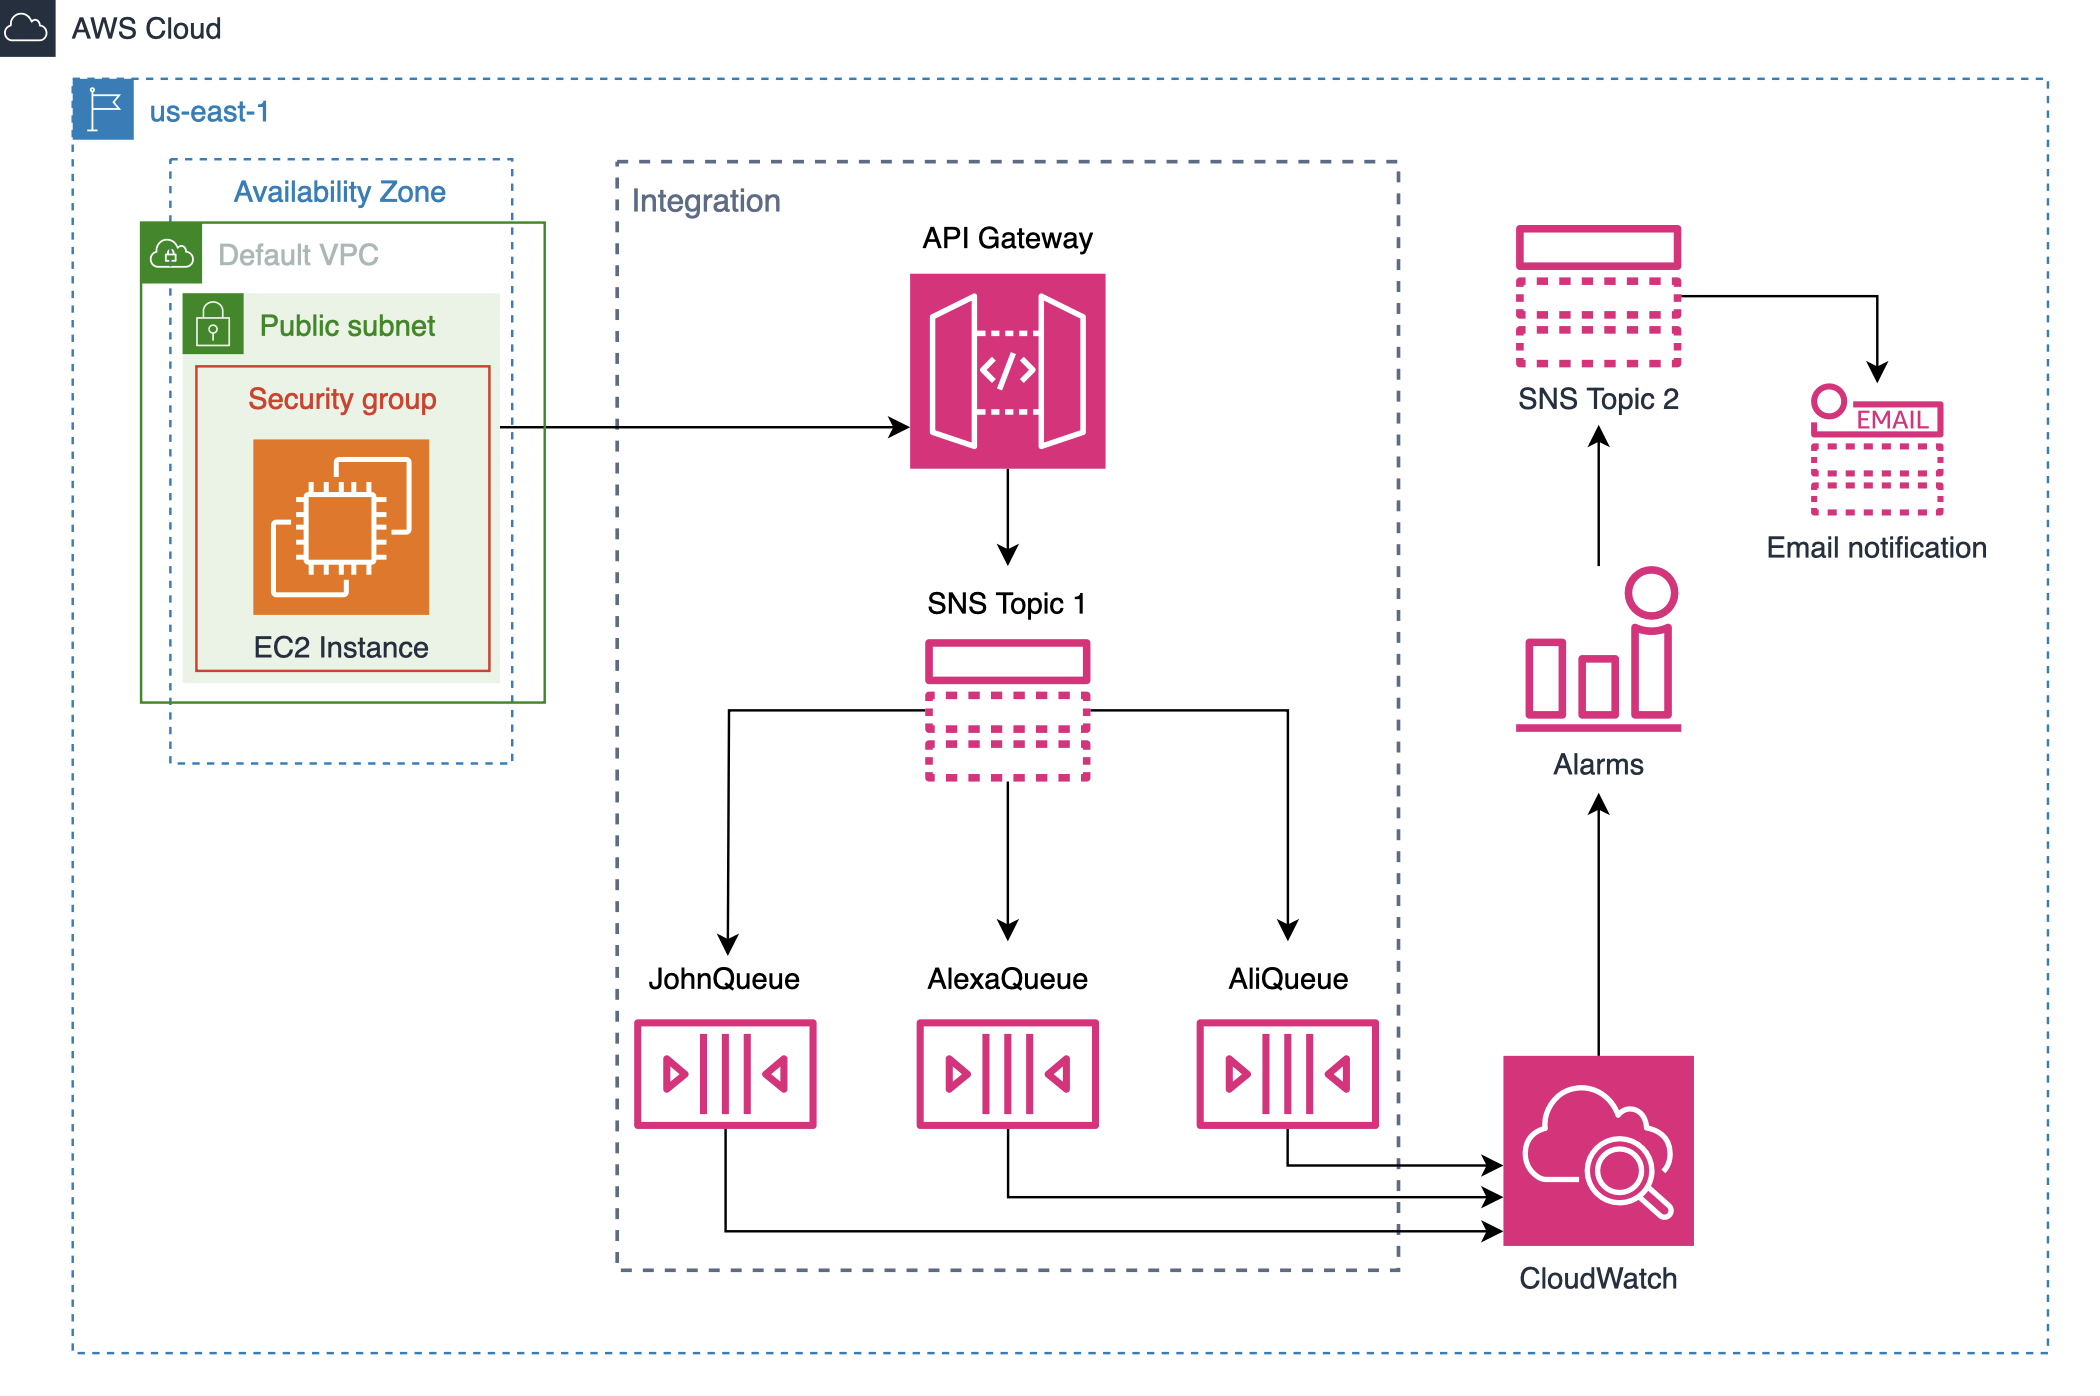

```bash
# Command to install git
sudo yum -y update && sudo yum -y install git && \

# Commands to install nodejs and npm.
sudo yum install https://rpm.nodesource.com/pub_16.x/nodistro/repo/nodesource-release-nodistro-1.noarch.rpm -y &&\
sudo yum install nodejs -y --setopt=nodesource-nodejs.module_hotfixes=1 && \

# Command to clone the required github repo
git clone https://github.com/Educative-Content/app-integration-services-zero-to-hero-cl-voting-app.git && \
cd app-integration-services-zero-to-hero-cl-voting-app && \
npm init -y && \
npm install && npm install express && npm install axios && \
nano app.js
```

where app.js looks like this
```javascript
const express = require('express');
const axios = require('axios');
const app = express();
const fs = require('fs');
const port = 3000;

app.use(express.static('public'));
app.use(express.urlencoded({ extended: true }));

app.get('/', (req, res) => {
  res.sendFile(__dirname + '/public/index.html');
});
restapi = '<restapiId>';
invokeurl = 'https://' + restapi + '.execute-api.us-east-1.amazonaws.com/';
// Handle the POST request from the frontend
app.post('', (req, res) => {
  const selectedOption = req.body.selectedOption;
  const apiUrl = invokeurl + 'v1/?message=' + selectedOption;
  console.log("done");
  console.log(apiUrl);
  
  axios
    .post(apiUrl, null, {
      params: { selectedOption: selectedOption },
    })
    .then((response) => {
      const indexContent = fs.readFileSync("./public/index.html", 'utf8');

      // Send the HTML content as the response
      res.send(indexContent);
    })
    .catch((error) => {
      console.error('Error:', error);
      res.status(500).send('Error posting to API Gateway');
    });
});

// Handle the GET request when the refresh button is clicked
app.get('/refresh', (req, res) => {
  
  let output1, output2, output3;

  // Request for John
  let johnApiUrl = invokeurl + 'Ali';
  axios.get(johnApiUrl)
    .then((response) => {
      console.log(response.data);
      output1 = response.data;

      // Request for Ali
      let aliApiUrl = invokeurl + 'John';
      return axios.get(aliApiUrl);
    })
    .then((response) => {
      console.log(response.data);
      output2 = response.data;

      // Request for Alexa
      let alexaApiUrl = invokeurl + 'Alexa';
      return axios.get(alexaApiUrl);
    })
    .then((response) => {
      console.log(response.data);
      output3 = response.data;

      // Send the combined response
      res.send({ val: output1, val1: output2, val2: output3 });
    })
    .catch((error) => {
      console.error('Error:', error);
      res.status(500).send('Error sending refresh request');
    });
});

app.listen(port, () => {
  console.log(`App is running on http://localhost:${port}`);
});
```